In [1]:
import sys
sys.path.append("/home/paj7rng/workspace/mobo_experiments/")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from blackboxopt import Objective, EvaluationSpecification
from benchmarks_multitask import Forrester
from optimizers.banner import BaNNER 

from plotting.banner_plots import plot_meta_mean_var, plot_metadata

In [3]:
benchmark = Forrester(n_data_per_task=[32] * 128)
meta_data = benchmark.get_meta_data(distribution='sobol')

## Meta-data

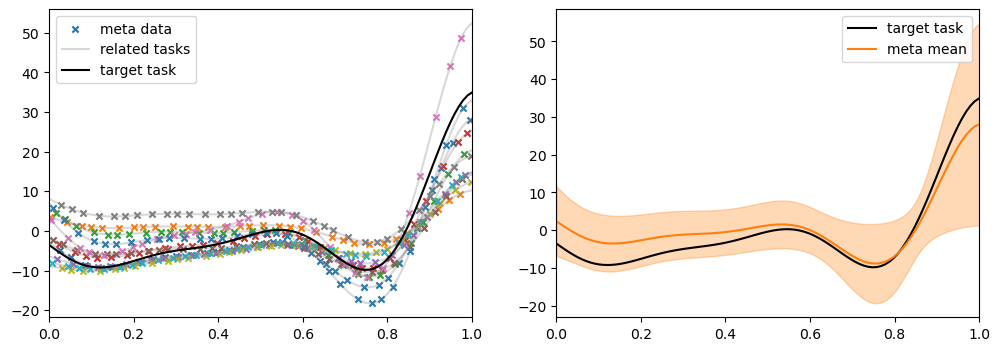

In [4]:
fig = plt.figure(figsize=(12, 4))

ax_meta = plt.subplot2grid((1, 2), (0, 0))
plot_metadata(benchmark, meta_data, ax_meta)

ax_mean_var = plt.subplot2grid((1, 2), (0, 1))
plot_meta_mean_var(benchmark, meta_data, ax_mean_var)

## Meta-learning

In [5]:
meta_model_config = {
    "num_layers": 5,
    "num_features": 2,
    "num_hidden_units": 64,
    "device": "cpu"
}
train_config = {
    "num_epochs": 100,
    "batch_size": 64,
}

model = BaNNER(benchmark.search_space, **meta_model_config)
model.meta_fit(meta_data=meta_data, **train_config)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
x_dense = np.linspace(0, 1, 100).reshape(-1, 1)
mean, var = model.predict(x_dense)

with torch.no_grad():
    embeddings = model.meta_blr.meta_model.task_embedding(torch.LongTensor(list(range(1, 129))))

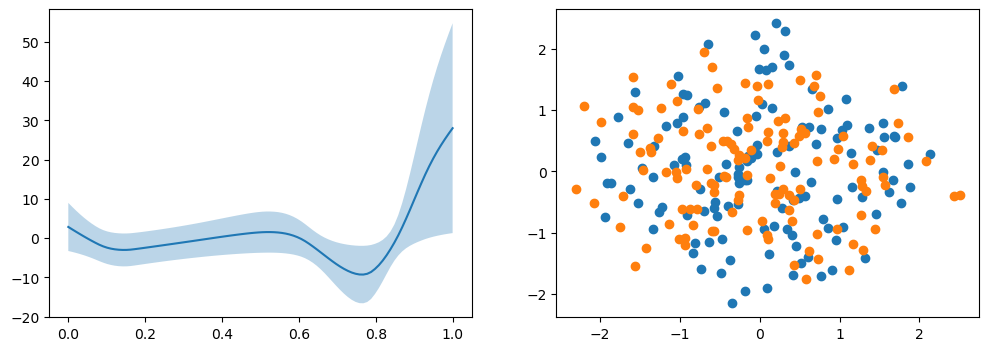

In [7]:
fig = plt.figure(figsize=(12, 4))
ax_meta = plt.subplot2grid((1, 2), (0, 0))
ax_meta.plot(x_dense, mean)
ax_meta.fill_between(
    x_dense.squeeze(),
    (mean + 2*np.sqrt(var)).squeeze(),
    (mean - 2*np.sqrt(var)).squeeze(),
    alpha=.3
)
ax_embeddding = plt.subplot2grid((1, 2), (0, 1))
ax_embeddding.scatter(embeddings[:, 0], embeddings[:, 1])

prior_samples = torch.randn(model.meta_blr.meta_model.task_embedding.weight[1:].shape)
ax_embeddding.scatter(prior_samples[:, 0], prior_samples[:, 1]);